# **First Step: Data collection, data visualization and preprocessing**

First we download the data using the command below

In [1]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 150MB/s]


importing the required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time


**Function explanation**:\
reproducible_random : gets a seed and a numpy array and randomizes the given data with the given seed\
rgb2gray : turns the given data from an rgb image to a gray one\
preprocess_image : normalizes the given data and randomizes both the given images and labels in a similar way\
read_data : reads all datas in the specified folder (the classes array) and also generates an one-hot encoding for labels

In [3]:
def reproducible_random(seed, data):
    np.random.seed(seed)
    np.random.shuffle(data)
    return data


def rgb2gray(rgb):
    r, g, b = rgb[:, :, :, 0], rgb[:, :, :, 1], rgb[:, :, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


def preprocess_image(images, labels):
    images = rgb2gray(images)
    images /= 255
    images = np.reshape(images, (-1, 1024, 1))
    seed = int(random.random() * 100000000)
    images = reproducible_random(seed, images)
    labels = reproducible_random(seed, labels)
    return images, labels


def read_data(path, size):
    classes = ["/cat", "/bird", "/automobile", "/airplane"]
    data_set = np.zeros((size, 32, 32, 3))
    one_hot = np.zeros((size, 4))
    index = 0
    for c in classes:
        for filename in os.listdir(path + c):
            image = plt.imread(path + c + "/" + filename)
            if image is not None:
                data_set[index] = image

                # initializing the labels
                if c == "/cat":
                    one_hot[index] = [1, 0, 0, 0]
                elif c == "/bird":
                    one_hot[index] = [0, 1, 0, 0]
                elif c == "/automobile":
                    one_hot[index] = [0, 0, 1, 0]
                elif c == "/airplane":
                    one_hot[index] = [0, 0, 0, 1]
                index += 1
    return data_set, np.reshape(one_hot, (-1, 4, 1))


In [4]:
test_images = np.zeros((4000, 32, 32, 3))
test_labels = np.zeros((4000, 4))
train_images = np.zeros((20000, 32, 32, 3))
train_labels = np.zeros((20000, 4))

test_images, test_labels = read_data("CIFAR10/test", 4000)
train_images, train_labels = read_data("CIFAR10/train", 20000)
train_images, train_labels = preprocess_image(train_images, train_labels)
test_images, test_labels = preprocess_image(test_images, test_labels)

# **Second Step: Feedforward**

for the given weights and biases the function starts to traverese the neural network layer by layer (the given weights are random at first and biases are also all zero)

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def weights_and_biases_generator():
    weights = []
    biases = []
    weights.append(np.random.rand(16, 1024) * 2 - 1)
    weights.append(np.random.rand(16, 16) * 2 - 1)
    weights.append(np.random.rand(4, 16) * 2 - 1)
    biases.append(np.zeros((16, 1)))
    biases.append(np.zeros((16, 1)))
    biases.append(np.zeros((4, 1)))
    return weights, biases


def feed_forward(images, weights, biases):
    hidden_layers_input = []
    hidden_layers_output = []
    hidden_layers_input.append(np.dot(weights[0], images) + biases[0])  # (16, 1)
    hidden_layers_output.append(sigmoid(hidden_layers_input[0]))
    hidden_layers_input.append(np.dot(weights[1], hidden_layers_output[0]) + biases[1])  # (16, 1)
    hidden_layers_output.append(sigmoid(hidden_layers_input[1]))
    hidden_layers_input.append(np.dot(weights[2], hidden_layers_output[1]) + biases[2])  # (4, 1)
    hidden_layers_output.append(sigmoid(hidden_layers_input[2]))
    return [images] + hidden_layers_input, [images] + hidden_layers_output

In [6]:
weights, biases = weights_and_biases_generator()
correct = 0
for i in range(200):
    trash, output = feed_forward(train_images[i], weights, biases)
    if np.argmax(output[3]) == np.argmax(train_labels[i]):
        correct += 1
print("Accuracy:")
print(correct / 200)

Accuracy:
0.3


# **Third Step: Backpropagation (using for-loops)**

First we need some funcions such as squared error and derivative of it, sigmoid and derivative of it and zeros_generator(used to create base numpy arrays for dw, db, grad_w , grad_b)

In [7]:
def squared_error(predicted_labels, correct_labels):
    return np.sum((predicted_labels - correct_labels) ** 2)


def derivative_squared_error(predicted_labels, correct_labels):
    return 2 * (predicted_labels - correct_labels)


def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))


def zeros_generator():
    x = []
    y = []
    x.append(np.zeros((16, 1024)))
    x.append(np.zeros((16, 16)))
    x.append(np.zeros((4, 16)))
    y.append(np.zeros((16, 1)))
    y.append(np.zeros((16, 1)))
    y.append(np.zeros((4, 1)))
    return x, y


def create_plot(arr):
    plt.plot(arr)
    plt.show()

The main SGD function using for-loops

In [16]:
def stochastic_gradient_descent_for_loops(images, labels):
    weights, biases = weights_and_biases_generator()
    accuracy = 0
    costs = []
    learning_rate = 0.3
    epoch = 10
    batch_size = 16
    for q in range(epoch):
        correct = 0
        incorrect = 0
        sum_cost = 0
        seed = int(random.random() * 100000000)
        images = reproducible_random(seed, images)
        labels = reproducible_random(seed, labels)
        batch_datas = [images[k:k + batch_size] for k in range(0, len(images), batch_size)]
        batch_labels = [labels[k:k + batch_size] for k in range(0, len(images), batch_size)]

        for batch_data, batch_label in zip(batch_datas, batch_labels):
            grad_w, grad_b = zeros_generator()
            for image, label in zip(batch_data, batch_label):
                dw, db = zeros_generator()
                z, activation = feed_forward(image, weights, biases)
                sum_cost += squared_error(activation[-1], label)
                predicted_label = np.argmax(activation[-1][:, 0])
                correct_label = np.argmax(label)
                if predicted_label == correct_label:
                    correct += 1
                else:
                    incorrect += 1

                delta = derivative_squared_error(activation[-1], label) * sigmoid_prime(z[-1])
                db[2] = delta
                res = []
                for w in range(len(delta)):
                    row = []
                    for e in range(len(np.transpose(activation[2])[0])):
                        product = 0
                        for r in range(len(delta[w])):
                            product += delta[w][r] * np.transpose(activation[2])[r][e]
                        row.append(product)
                    res.append(row)
                dw[2] = res
                delta = (np.transpose(weights[2]) @ delta) * sigmoid_prime(z[-2])
                db[1] = delta

                res = []
                for w in range(len(delta)):
                    row = []
                    for e in range(len(np.transpose(activation[1])[0])):
                        product = 0
                        for r in range(len(delta[w])):
                            product += delta[w][r] * np.transpose(activation[1])[r][e]
                        row.append(product)
                    res.append(row)
                dw[1] = res
                delta = (np.transpose(weights[1]) @ delta) * sigmoid_prime(z[-3])
                db[0] = delta
                res = []
                for w in range(len(delta)):
                    row = []
                    for e in range(len(np.transpose(activation[0])[0])):
                        product = 0
                        for r in range(len(delta[w])):
                            product += delta[w][r] * np.transpose(activation[0])[r][e]
                        row.append(product)
                    res.append(row)
                dw[0] = res

                for i in range(3):
                    grad_w[i] += dw[i]
                    grad_b[i] += db[i]
            for j in range(3):
                weights[j] -= (learning_rate * (grad_w[j] / len(batch_data)))
                biases[j] -= (learning_rate * (grad_b[j] / len(batch_data)))
        costs.append(sum_cost)
        accuracy += correct / (correct + incorrect)
    return costs, accuracy / 10

Executed time:
184.90154361724854
Average accuracy: 
0.2715


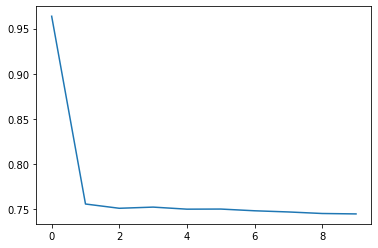

In [18]:
start_time = time.time()
costs = np.zeros((1, 10))
this_cost, this_accuracy = stochastic_gradient_descent_for_loops(train_images[:200], train_labels[:200])
costs += this_cost
print("Executed time:")
print(time.time() - start_time)
print("Average accuracy: ")
print(this_accuracy)
costs /= 200
create_plot(costs[0])

# **Fourth Step: Vectorized SGD Function**

In [8]:
def stochastic_gradient_descent(images, labels):
    weights, biases = weights_and_biases_generator()
    accuracy = 0
    costs = []
    learning_rate = 0.3
    epoch = 20
    batch_size = 16
    for q in range(epoch):
        correct = 0
        incorrect = 0
        sum_cost = 0
        seed = int(random.random() * 100000000)
        images = reproducible_random(seed, images)
        labels = reproducible_random(seed, labels)
        batch_datas = [images[k:k + batch_size] for k in range(0, len(images), batch_size)]
        batch_labels = [labels[k:k + batch_size] for k in range(0, len(images), batch_size)]

        for batch_data, batch_label in zip(batch_datas, batch_labels):
            grad_w, grad_b = zeros_generator()
            for image, label in zip(batch_data, batch_label):
                dw, db = zeros_generator()
                z, activation = feed_forward(image, weights, biases)
                sum_cost += squared_error(activation[-1], label)
                predicted_label = np.argmax(activation[-1][:, 0])
                correct_label = np.argmax(label)
                if predicted_label == correct_label:
                    correct += 1
                else:
                    incorrect += 1

                delta = derivative_squared_error(activation[-1], label) * sigmoid_prime(z[-1])
                db[2] = delta
                dw[2] = (delta @ np.transpose(activation[2]))
                delta = (np.transpose(weights[2]) @ delta) * sigmoid_prime(z[-2])
                db[1] = delta
                dw[1] = (delta @ np.transpose(activation[1]))
                delta = (np.transpose(weights[1]) @ delta) * sigmoid_prime(z[-3])
                db[0] = delta
                dw[0] = (delta @ np.transpose(activation[0]))

                for i in range(3):
                    grad_w[i] += dw[i]
                    grad_b[i] += db[i]
            for j in range(3):
                weights[j] -= (learning_rate * (grad_w[j] / len(batch_data)))
                biases[j] -= (learning_rate * (grad_b[j] / len(batch_data)))
        costs.append(sum_cost)
        accuracy += correct/(correct+incorrect)
    return costs, accuracy/20

Average executed time:
1.534672451019287
Average accuracy: 
0.3746


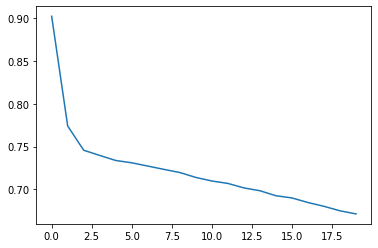

In [13]:
start_time = time.time()
costs = np.zeros((1, 20))
accuracy = 0
for i in range(10):
    this_cost, this_accuracy = stochastic_gradient_descent(train_images[:200], train_labels[:200])
    costs += this_cost
    accuracy += this_accuracy
print("Average executed time:")
print((time.time() - start_time)/10)
print("Average accuracy: ")
print(accuracy/10)
costs /= 2000
create_plot(costs[0])

# **Final Step: Testing**

In [19]:
def stochastic_gradient_descent_final(images, labels, weights, biases):
    accuracy = 0
    costs = []
    learning_rate = 0.3
    epoch = 40
    batch_size = 16
    for q in range(epoch):
        correct = 0
        incorrect = 0
        sum_cost = 0
        seed = int(random.random() * 100000000)
        images = reproducible_random(seed, images)
        labels = reproducible_random(seed, labels)
        batch_datas = [images[k:k + batch_size] for k in range(0, len(images), batch_size)]
        batch_labels = [labels[k:k + batch_size] for k in range(0, len(images), batch_size)]

        for batch_data, batch_label in zip(batch_datas, batch_labels):
            grad_w, grad_b = zeros_generator()
            for image, label in zip(batch_data, batch_label):
                dw, db = zeros_generator()
                z, activation = feed_forward(image, weights, biases)
                sum_cost += squared_error(activation[-1], label)
                predicted_label = np.argmax(activation[-1][:, 0])
                correct_label = np.argmax(label)
                if predicted_label == correct_label:
                    correct += 1
                else:
                    incorrect += 1

                delta = derivative_squared_error(activation[-1], label) * sigmoid_prime(z[-1])
                db[2] = delta
                dw[2] = (delta @ np.transpose(activation[2]))
                delta = (np.transpose(weights[2]) @ delta) * sigmoid_prime(z[-2])
                db[1] = delta
                dw[1] = (delta @ np.transpose(activation[1]))
                delta = (np.transpose(weights[1]) @ delta) * sigmoid_prime(z[-3])
                db[0] = delta
                dw[0] = (delta @ np.transpose(activation[0]))

                for i in range(3):
                    grad_w[i] += dw[i]
                    grad_b[i] += db[i]
            for j in range(3):
                weights[j] -= (learning_rate * (grad_w[j] / len(batch_data)))
                biases[j] -= (learning_rate * (grad_b[j] / len(batch_data)))
        costs.append(sum_cost)
        accuracy += correct/(correct+incorrect)
    return costs, accuracy/40, weights, biases

Average train accuracy: 
0.40785
Average test accuracy: 
0.5251693749999999


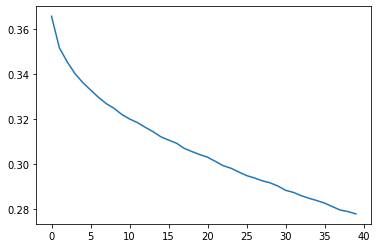

In [21]:
costs = np.zeros((1, 40))
train_accuracy = 0
test_accuracy = 0
for i in range(10):
    weights, biases = weights_and_biases_generator()
    this_cost, this_accuracy, train_weights, train_biases = stochastic_gradient_descent_final(train_images[:200], train_labels[:200], weights, biases)
    costs += this_cost
    train_accuracy += this_accuracy

    this_cost, this_accuracy, trash, trash2 = stochastic_gradient_descent_final(test_images, test_labels, train_weights, train_biases)
    costs += this_cost
    test_accuracy += this_accuracy

print("Average train accuracy: ")
print(train_accuracy/10)
print("Average test accuracy: ")
print(test_accuracy/10)
costs /= (2000 + 80000)
create_plot(costs[0])

# **Extras: CNN**

First we import the libraries that we need

In [61]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, losses
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Loading the dataset

In [44]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ["airplane", "automobile", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [45]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2,2)),
    
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),
    ])

In [46]:
model.compile(loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [47]:
history = model.fit(train_images, train_labels, batch_size=50, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1000/1000 [==============================] - 33s 31ms/step - loss: 1.6204 - accuracy: 0.4098 - val_loss: 1.1599 - val_accuracy: 0.5854
Epoch 2/10
1000/1000 [==============================] - 27s 27ms/step - loss: 1.0445 - accuracy: 0.6297 - val_loss: 0.9541 - val_accuracy: 0.6723
Epoch 3/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.8258 - accuracy: 0.7145 - val_loss: 0.9668 - val_accuracy: 0.6786
Epoch 4/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.7024 - accuracy: 0.7585 - val_loss: 0.7985 - val_accuracy: 0.7336
Epoch 5/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.6230 - accuracy: 0.7878 - val_loss: 0.8346 - val_accuracy: 0.7219
Epoch 6/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.5770 - accuracy: 0.8048 - val_loss: 0.7353 - val_accuracy: 0.7551
Epoch 7/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.5459 - accuracy: 0.8169 - val_loss: 0.7461 -

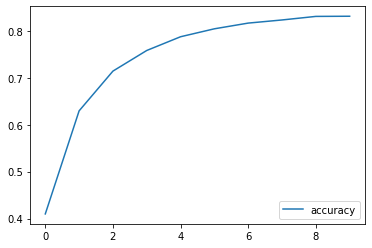

In [48]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(loc='lower right')

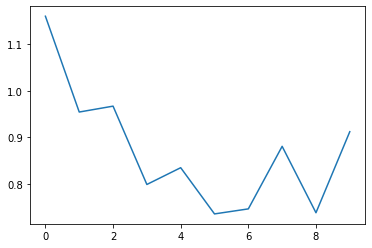

In [49]:
plt.plot(history.history['val_loss'], label='validation loss')

In [ ]:
# confusion matrix

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

In [64]:
model1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),
    ])


In [67]:
model1.compile(loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [68]:
history = model1.fit(train_images, train_labels, batch_size=50, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1000/1000 [==============================] - 44s 42ms/step - loss: 1.3281 - accuracy: 0.5286 - val_loss: 1.0411 - val_accuracy: 0.6350
Epoch 2/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.8175 - accuracy: 0.7154 - val_loss: 0.8020 - val_accuracy: 0.7217
Epoch 3/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.6405 - accuracy: 0.7786 - val_loss: 1.0243 - val_accuracy: 0.6882
Epoch 4/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.5183 - accuracy: 0.8207 - val_loss: 0.7041 - val_accuracy: 0.7720
Epoch 5/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.4299 - accuracy: 0.8531 - val_loss: 0.8210 - val_accuracy: 0.7500
Epoch 6/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.3532 - accuracy: 0.8781 - val_loss: 0.7162 - val_accuracy: 0.7809
Epoch 7/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2913 - accuracy: 0.9023 - val_loss: 0.7684 -

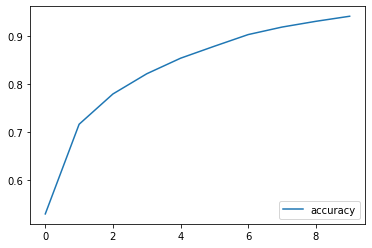

In [72]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(loc='lower right')

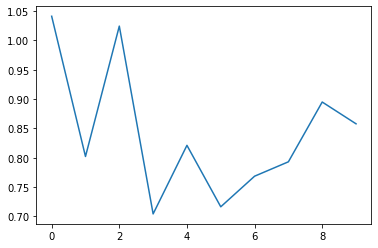

In [73]:
plt.plot(history.history['val_loss'], label='validation loss')

In [ ]:
# confusion matrix

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1

In [74]:
model2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(64, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax'),
    ])


In [75]:
model2.compile(loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [76]:
history = model2.fit(train_images, train_labels, batch_size=50, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1000/1000 [==============================] - 44s 42ms/step - loss: 1.5380 - accuracy: 0.4413 - val_loss: 2.1644 - val_accuracy: 0.3568
Epoch 2/10
1000/1000 [==============================] - 31s 31ms/step - loss: 1.0560 - accuracy: 0.6242 - val_loss: 1.3188 - val_accuracy: 0.5931
Epoch 3/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.8567 - accuracy: 0.7045 - val_loss: 0.9193 - val_accuracy: 0.7007
Epoch 4/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.7475 - accuracy: 0.7445 - val_loss: 0.7279 - val_accuracy: 0.7618
Epoch 5/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.6722 - accuracy: 0.7692 - val_loss: 0.7289 - val_accuracy: 0.7539
Epoch 6/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.6201 - accuracy: 0.7876 - val_loss: 0.7195 - val_accuracy: 0.7689
Epoch 7/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.5756 - accuracy: 0.8022 - val_loss: 0.6988 -

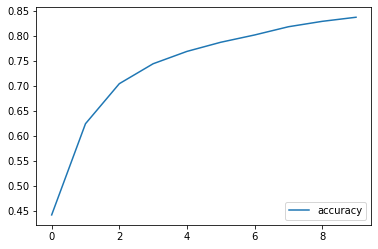

In [77]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(loc='lower right')

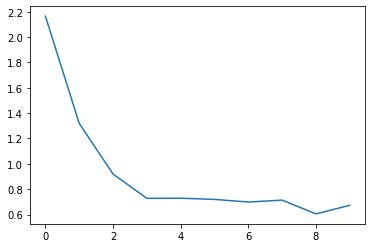

In [78]:
plt.plot(history.history['val_loss'], label='validation loss')

In [ ]:
# confusion matrix

we are going to use these 3 optimizers:\
 1-Adam: Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.\
2-SGD:Stochastic gradient descent (often abbreviated SGD) is an iterative method for optimizing an objective function with suitable smoothness properties.\
 3-adadelta: Adadelta optimizer. Adadelta is a more robust extension of Adagrad that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done.

In [80]:
model2.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [81]:
history = model2.fit(train_images, train_labels, batch_size=50, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1000/1000 [==============================] - 27s 26ms/step - loss: 0.4394 - accuracy: 0.8484 - val_loss: 0.7353 - val_accuracy: 0.7773
Epoch 2/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.4064 - accuracy: 0.8589 - val_loss: 0.5826 - val_accuracy: 0.8039
Epoch 3/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.3769 - accuracy: 0.8677 - val_loss: 0.5036 - val_accuracy: 0.8337
Epoch 4/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.3567 - accuracy: 0.8752 - val_loss: 0.5501 - val_accuracy: 0.8175
Epoch 5/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.3334 - accuracy: 0.8823 - val_loss: 0.5104 - val_accuracy: 0.8333
Epoch 6/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.3164 - accuracy: 0.8873 - val_loss: 0.6270 - val_accuracy: 0.8021
Epoch 7/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.2994 - accuracy: 0.8948 - val_loss: 0.5422 -

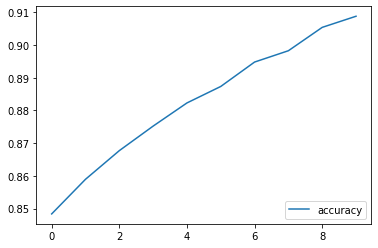

In [82]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(loc='lower right')

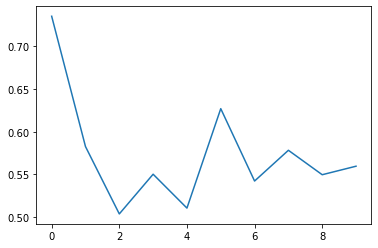

In [83]:
plt.plot(history.history['val_loss'], label='validation loss')

In [ ]:
# confusion matrix

In [84]:
model2.compile(optimizer='SGD', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [85]:
history = model2.fit(train_images, train_labels, batch_size=50, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1000/1000 [==============================] - 27s 26ms/step - loss: 0.1892 - accuracy: 0.9326 - val_loss: 0.5169 - val_accuracy: 0.8529
Epoch 2/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1808 - accuracy: 0.9347 - val_loss: 0.5038 - val_accuracy: 0.8551
Epoch 3/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1735 - accuracy: 0.9377 - val_loss: 0.5035 - val_accuracy: 0.8604
Epoch 4/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1684 - accuracy: 0.9401 - val_loss: 0.5123 - val_accuracy: 0.8582
Epoch 5/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.1659 - accuracy: 0.9405 - val_loss: 0.5195 - val_accuracy: 0.8569
Epoch 6/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1609 - accuracy: 0.9425 - val_loss: 0.5133 - val_accuracy: 0.8606
Epoch 7/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1579 - accuracy: 0.9430 - val_loss: 0.5264 -

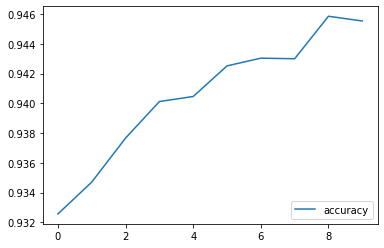

In [86]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(loc='lower right')

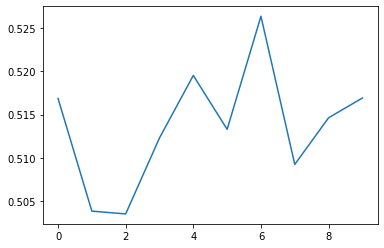

In [87]:
plt.plot(history.history['val_loss'], label='validation loss')

In [ ]:
# confusion matrix

In [88]:
model2.compile(optimizer='adadelta', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [89]:
history = model2.fit(train_images, train_labels, batch_size=50, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1000/1000 [==============================] - 33s 32ms/step - loss: 0.1450 - accuracy: 0.9480 - val_loss: 0.5088 - val_accuracy: 0.8621
Epoch 2/10
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1490 - accuracy: 0.9465 - val_loss: 0.5074 - val_accuracy: 0.8631
Epoch 3/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.1477 - accuracy: 0.9478 - val_loss: 0.5091 - val_accuracy: 0.8636
Epoch 4/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.1488 - accuracy: 0.9461 - val_loss: 0.5098 - val_accuracy: 0.8629
Epoch 5/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.1444 - accuracy: 0.9481 - val_loss: 0.5083 - val_accuracy: 0.8630
Epoch 6/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.1434 - accuracy: 0.9499 - val_loss: 0.5079 - val_accuracy: 0.8634
Epoch 7/10
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1448 - accuracy: 0.9478 - val_loss: 0.5078 -

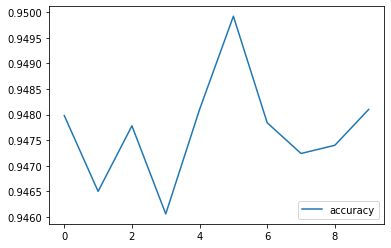

In [90]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(loc='lower right')

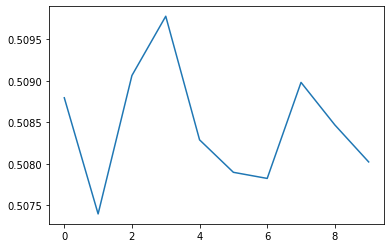

In [91]:
plt.plot(history.history['val_loss'], label='validation loss')

In [ ]:
# confusion matrix

# **Extras(2): Data Augmentation**

Data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.
\
Cropping, Adding noise, Flipping, Rotation, Scaling, Translation, Brightness, Contrast, Color augmentation, Saturation\
No. Data augmentation is only used for training.